## Transformer的简单实现。。
遇到困难请看论文图:
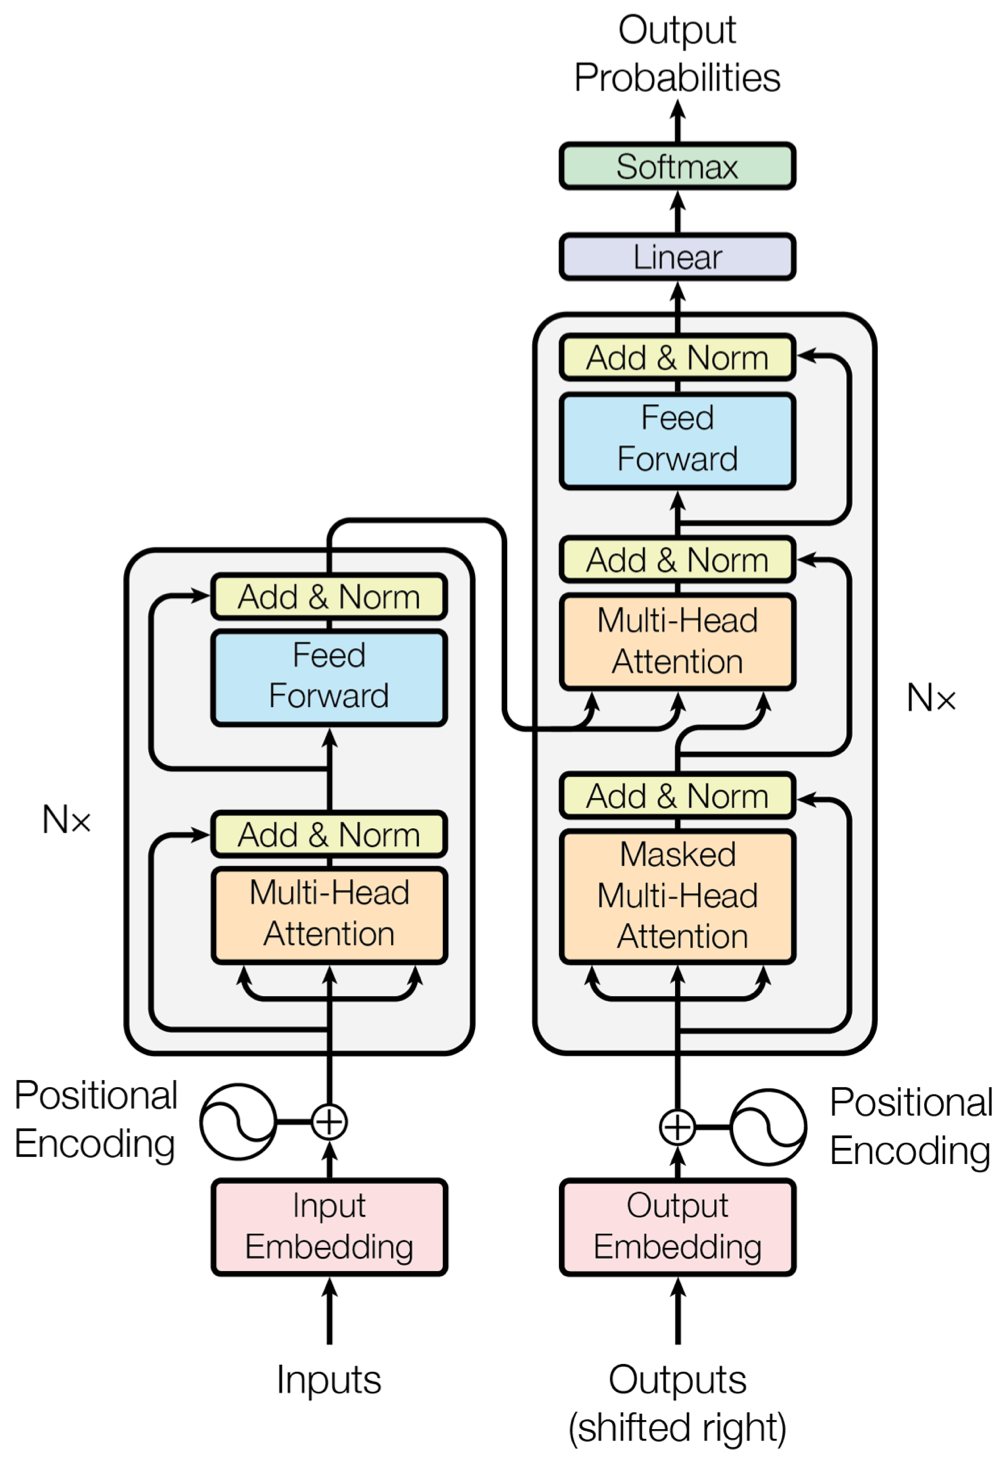
这里用transformer实现一个简单的文本情感分类
数据还是经典的IMDB（草
先安装一下datasets（以前居然没装。。。

In [1]:
#import sys
#!{sys.executable} -m pip install datasets
import torch
import torch.nn as nn
import torch.nn.functional as F
import math
import datasets
from collections import Counter
from datasets import load_dataset
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm

### 多头注意力机制的实现！
就是把很多个单头注意力机制叠起来，让模型能够从多个子空间中提取多个特征

In [2]:
#首先定义一个类
#是继承了 PyTorch 的 nn.Module 类，代表这个是一个可训练的神经网络模块
class MultiHeadSelfAttention(nn.Module):
    
    #--------------------------初始化部分（__init__）-------------------------
    #d_modle：输入序列中每个向量的维度（embedding的向量）
    #heads_num：设定的头数
    def __init__(self,d_modle,heads_num):
        super().__init__()
        assert d_modle%heads_num==0 #不能整除就报错
        self.d_k=d_modle//heads_num
        self.heads_num=heads_num
        #-----------------初始化线性层----------------
        #这里是把输入直接变成QKV。。详情见笔记
        self.q_linear=nn.Linear(d_modle,d_modle)
        self.k_linear=nn.Linear(d_modle,d_modle)
        self.v_linear=nn.Linear(d_modle,d_modle)
        self.out_linear=nn.Linear(d_modle,d_modle) #合成原本的维度输出（见论文里的图
 
    #----------------前向传播---------------
    #输入是x
    #x的维度：batch_size,seq_len,d_modle; 这里记为B，T，C
    def forward(self,x):
        B,T,C=x.size()
        q=self.q_linear(x)
        k=self.k_linear(x)
        v=self.v_linear(x)
        #-------------------分头--------------------
        #用.view reshape成多头
        #然后用.transpose 交换T和heads_num, 这样可以让每个头并行
        #现在qkv的维度是batchsize,头数,token数,分到每个头上的向量维度
        heads_num=self.heads_num
        d_k=self.d_k
        q=q.view(B,T,heads_num,d_k).transpose(1,2)
        k=k.view(B,T,heads_num,d_k).transpose(1,2)
        v=v.view(B,T,heads_num,d_k).transpose(1,2)
        #------------------计算attention分数--------------------
        #这里用论文里写的 Scaled Dot-Product Attention
        scores=torch.matmul(q,k.transpose(-2,-1))
        scores=scores/math.sqrt(d_k) #防止梯度消失
        #------------------得到注意力后权重----------------------
        attn=F.softmax(scores,dim=-1)
        #------------------加权和-----------------------
        context=torch.matmul(attn,v)
        #------------------把头重新合起来------------------
        #拼起来再换和换了再拼随便...
        context=context.transpose(1,2)
        context=context.contiguous().view(B,T,C)
        #拼接的多个头输出融合成最终的分数
        return self.out_linear(context)
        

### 前馈神经模块 feedforward

In [3]:
class FeedForward(nn.Module):
    #---------------------初始化-----------------
    def __init__(self,d_model,d_ff):
        super().__init__()
        #d_ff 隐藏层维数,一般比d_model大
        #扩展...压缩
        self.net=nn.Sequential(
            nn.Linear(d_model,d_ff),
            nn.ReLU(),
            nn.Linear(d_ff,d_model)
        )
    #-----------------------前向传播-------------------------
    def forward(self,x):
        return self.net(x)

        

### 位置编码模块 positional encoding
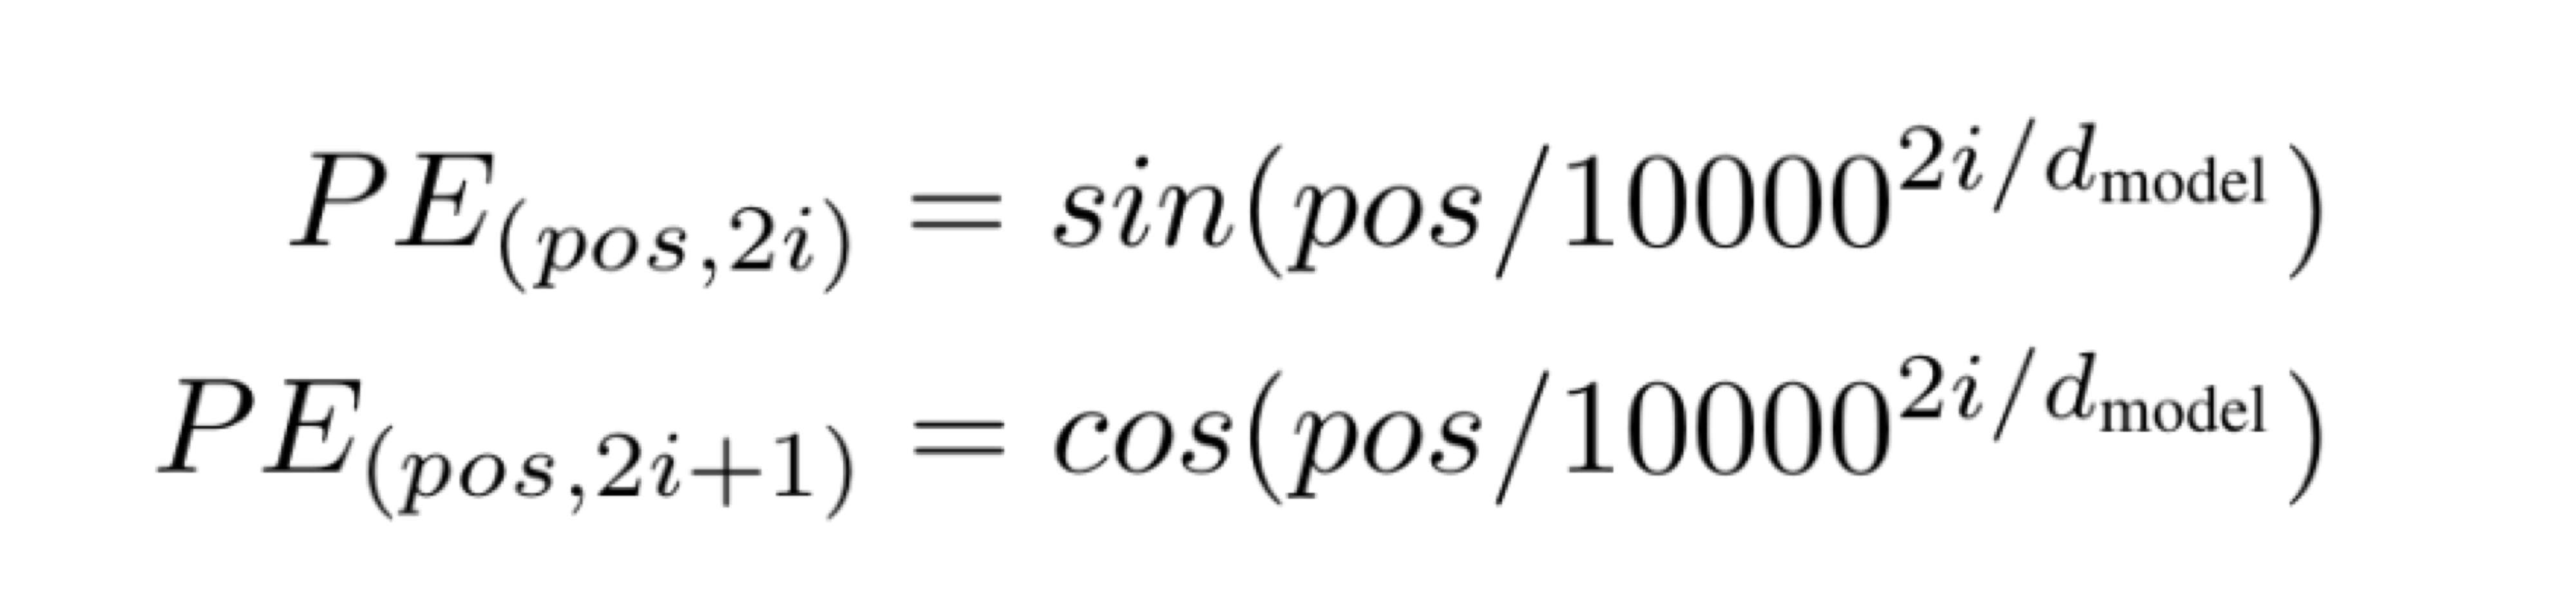
这里是固定不可学习的

In [4]:
class PositionalEncoding(nn.Module):
    def __init__(self,d_model,max_len=512):
        super().__init__()
        #位置编码矩阵pe
        pe=torch.zeros(max_len,d_model)
        #position 每个位置的编号
        position=torch.arange(0,max_len,dtype=torch.float)
        position=torch.unsqueeze(position,1)
        #div_term就是trick(见上图
        div_term=torch.exp(torch.arange(0,d_model,2).float())
        div_term=div_term*(-math.log(10000.0)/d_model)
        #奇偶维度(看上面的公式)
        #偶数
        pe[:,0::2]=torch.sin(position/div_term)
        #奇数
        pe[:,1::2]=torch.cos(position/div_term)
        #-------------增加维度,可以embbeding直接相加-------------
        #增加一个batchsize的维度,现在的形状是[1,max_len,d_model]
        pe=pe.unsqueeze(0)
        self.register_buffer('pe',pe)#不参与训练,仅保存
        
    #--------------------前向传播------------------------
    def forward(self,x):
        #只取句子长度的编码,后面的无意义
        return x+self.pe[:,:x.size(1)]






### 整合成一个transformerblock
多个transformerblock叠起来就是encoder啦

In [5]:
class TransformerBlock(nn.Module):
    def __init__(self,d_model,heads_num,d_ff):
        super().__init__()
        self.attn=MultiHeadSelfAttention(d_model,heads_num)
        self.ff=FeedForward(d_model,d_ff)
        #--------------------layernorm 层归一化---------------------
        #稳定训练效果..
        self.norm1=nn.LayerNorm(d_model)
        self.norm2=nn.LayerNorm(d_model)

    #--------------看图------------------
    def forward(self,x):
        #MultiHeadSelfAttention只接收x(看这个模块的forward
        #output=self.attn(x)实际上是在调用类中定义的forward()方法
        #等价于output=self.attn.forward(x)
        x=x+self.attn(self.norm1(x))
        x=x+self.ff(self.norm2(x))
        return x



        

### Encoder
和图一样,设定输入参数+叠叠乐
ps：
nn.ModuleList([...]) 只是“创建和存储多个子模块”，并不会自动执行 forward，类似一排工具箱，你要手动取出来一个个执行它们。

In [6]:
class TransformerEncoder(nn.Module):
    #vocab_size 词汇表大小
    def __init__(self,vocab_size,d_model,heads_num,d_ff,num_layers,max_len):
        super().__init__()

        #-------------------词嵌入层------------------
        self.embed=nn.Embedding(vocab_size,d_model)
        #-------------------位置编码层------------------
        self.pos_encoding=PositionalEncoding(d_model,max_len)
        #-------------------叠叠乐--------------------
        self.layers=nn.ModuleList([
            TransformerBlock(d_model,heads_num,d_ff) for _ in range(num_layers)
        ])
        #------------------最后再layernorm一下---------------
        self.norm=nn.LayerNorm(d_model)
        
    #----------------叠叠乐,请看大图-------------------
    def forward(self,x):
        x=self.embed(x)
        x=self.pos_encoding(x)
        for layer in self.layers:
            x=layer(x)
        return self.norm(x)





    

### 整个分类模型！
因为只用得到输入分数所以不用构造decoder。。


In [7]:
class TransformerClassification(nn.Module):
    #num_classes 类别数,这里只有2
    def __init__(self,vocab_size,d_model,heads_num,d_ff,num_layers,max_len,num_classes,pad_id):
        super().__init__()
        self.pad_id = pad_id
        #----------------------Encoder部分----------------------
        self.encoder=TransformerEncoder(vocab_size,d_model,heads_num,d_ff,num_layers,max_len)
        #----------------------分类器---------------------------
        #在训练时 nn.CrossEntropyLoss() 会自动加 softmax
        self.classifier=nn.Linear(d_model,num_classes)

    def forward(self,x):
        #-----------------句向量,这里用mean pooling----------------
        #如果有padding就遮住padding部分
        mask=(x!=self.pad_id).unsqueeze(-1)#形状 [batch_size,seq_len,1],不是pad就是1,是pad就是0
        x=self.encoder(x)
        #将pad部分的向量置零向量
        x=x*mask
        x=x.sum(dim=1)/mask.sum(dim=1)
        return self.classifier(x)


      


        

### 数据处理

加载数据集...我直接下到本地了,用pandas读取csv文件即可,需要把sentiment转化一下变成1和0
下载链接: https://www.kaggle.com/datasets/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews?resource=download

In [8]:
import pandas as pd

df = pd.read_csv("DATA/IMDB Dataset.csv")
df["label"] = df["sentiment"].map({"negative": 0, "positive": 1})

dataset = [{"text": row["review"], "label": row["label"]} for _, row in df.iterrows()]


In [9]:
PAD = "<PAD>"
UNK = "<UNK>"
def simple_tokenizer(text):
    return text.lower().split()

def build_vocab(dataset, max_vocab_size=10000):
    word_counts = Counter()
    for item in dataset:
        tokens = simple_tokenizer(item["text"])
        word_counts.update(tokens)
    vocab = {PAD: 0, UNK: 1}
    for word, _ in word_counts.most_common(max_vocab_size):
        vocab[word] = len(vocab)
    return vocab



def encode(text, vocab, max_len=128):
    tokens = simple_tokenizer(text)
    ids = [vocab.get(t, vocab[UNK]) for t in tokens][:max_len]
    ids += [vocab[PAD]] * (max_len - len(ids))
    return ids

class IMDBDataset(Dataset):
    def __init__(self, data, vocab, max_len=128):
        self.data = data
        self.vocab = vocab
        self.max_len = max_len

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        text = self.data[idx]["text"]
        label = self.data[idx]["label"]
        input_ids = encode(text, self.vocab, self.max_len)
        return torch.tensor(input_ids), torch.tensor(label)



### 训练!

In [12]:
def train_model():
    train_data = dataset[:40000]
    test_data = dataset[40000:]  #看了一眼只有50000条数据
    
    vocab = build_vocab(train_data)
    PAD_ID = vocab[PAD]  # 获取 <PAD> token 对应的 id
    train_dataset = IMDBDataset(train_data, vocab)
    test_dataset = IMDBDataset(test_data, vocab)

    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=32)

    model = TransformerClassification(
        vocab_size=len(vocab),
        d_model=64,
        heads_num=8,
        d_ff=128,
        num_layers=8,
        max_len=128,
        num_classes=2,
        pad_id=PAD_ID
    )

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = model.to(device)
    loss_fn = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

    for epoch in range(11):
        model.train()
        total_loss = 0
        for x, y in tqdm(train_loader, desc=f"Epoch {epoch+1}"):
            x, y = x.to(device), y.to(device)
            logits = model(x)
            loss = loss_fn(logits, y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f"Epoch {epoch+1}, Loss: {total_loss:.4f}")

        # Evaluation
        model.eval()
        correct = total = 0
        with torch.no_grad():
            for x, y in test_loader:
                x, y = x.to(device), y.to(device)
                logits = model(x)
                pred = torch.argmax(logits, dim=1)
                correct += (pred == y).sum().item()
                total += y.size(0)
        print(f"Test Accuracy: {correct / total:.4f}")
        #保存.........
        torch.save(model,"MODEL/transformer_sentiment.pth")
    return model, vocab, device

model, vocab, device = train_model()


Epoch 1: 100%|██████████████████████████████| 1250/1250 [02:45<00:00,  7.57it/s]


Epoch 1, Loss: 787.4747
Test Accuracy: 0.6708


Epoch 2: 100%|██████████████████████████████| 1250/1250 [02:48<00:00,  7.41it/s]


Epoch 2, Loss: 645.6718
Test Accuracy: 0.7613


Epoch 3: 100%|██████████████████████████████| 1250/1250 [02:54<00:00,  7.15it/s]


Epoch 3, Loss: 587.8848
Test Accuracy: 0.7776


Epoch 4: 100%|██████████████████████████████| 1250/1250 [02:47<00:00,  7.48it/s]


Epoch 4, Loss: 543.2395
Test Accuracy: 0.7909


Epoch 5: 100%|██████████████████████████████| 1250/1250 [02:45<00:00,  7.57it/s]


Epoch 5, Loss: 513.4817
Test Accuracy: 0.7958


Epoch 6: 100%|██████████████████████████████| 1250/1250 [02:44<00:00,  7.59it/s]


Epoch 6, Loss: 480.6835
Test Accuracy: 0.8046


Epoch 7: 100%|██████████████████████████████| 1250/1250 [02:42<00:00,  7.67it/s]


Epoch 7, Loss: 454.9637
Test Accuracy: 0.8092


Epoch 8: 100%|██████████████████████████████| 1250/1250 [02:59<00:00,  6.96it/s]


Epoch 8, Loss: 429.6321
Test Accuracy: 0.8147


Epoch 9: 100%|██████████████████████████████| 1250/1250 [03:09<00:00,  6.60it/s]


Epoch 9, Loss: 403.8815
Test Accuracy: 0.8098


Epoch 10: 100%|█████████████████████████████| 1250/1250 [02:53<00:00,  7.21it/s]


Epoch 10, Loss: 380.0688
Test Accuracy: 0.8158


Epoch 11: 100%|█████████████████████████████| 1250/1250 [02:44<00:00,  7.59it/s]


Epoch 11, Loss: 351.8591
Test Accuracy: 0.8129


### 用训练好的模型试着玩(不是

In [20]:
import torch
import pickle

#加载模型并保存vocab
model_name="transformer_sentiment"
vocab_path = f"MODEL/{model_path}_vocab.pkl"
with open(vocab_path, "wb") as f:
    pickle.dump(vocab, f)

# 设置设备
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 加载模型
model = torch.load(f"MODEL/{model_name}.pth")
model = model.to(device)
model.eval()

# 预测函数
def predict_sentiment(model, vocab, device, sentence):
    model.eval()
    input_ids = encode(sentence, vocab)
    input_tensor = torch.tensor([input_ids]).to(device)
    with torch.no_grad():
        logits = model(input_tensor)
        pred = torch.argmax(logits, dim=1).item()
    return "positive" if pred == 1 else "negative"

# 示例预测
for sentence in [
    "This movie was good",
    "This movie is my favourite",
    "One of the other reviewers has mentioned that after watching just 1 Oz episode you'll be hooked. They are right, as this is exactly what happened with me.<br /><br />The first thing that struck me about Oz was its brutality and unflinching scenes of violence, which set in right from the word GO. Trust me, this is not a show for the faint hearted or timid. This show pulls no punches with regards to drugs, sex or violence. Its is hardcore, in the classic use of the word.<br /><br />It is called OZ as that is the nickname given to the Oswald Maximum Security State Penitentary. It focuses mainly on Emerald City, an experimental section of the prison where all the cells have glass fronts and face inwards, so privacy is not high on the agenda. Em City is home to many..Aryans, Muslims, gangstas, Latinos, Christians, Italians, Irish and more....so scuffles, death stares, dodgy dealings and shady agreements are never far away.<br /><br />I would say the main appeal of the show is due to the fact that it goes where other shows wouldn't dare. Forget pretty pictures painted for mainstream audiences, forget charm, forget romance...OZ doesn't mess around. The first episode I ever saw struck me as so nasty it was surreal, I couldn't say I was ready for it, but as I watched more, I developed a taste for Oz, and got accustomed to the high levels of graphic violence. Not just violence, but injustice (crooked guards who'll be sold out for a nickel, inmates who'll kill on order and get away with it, well mannered, middle class inmates being turned into prison bitches due to their lack of street skills or prison experience) Watching Oz, you may become comfortable with what is uncomfortable viewing....thats if you can get in touch with your darker side.",
    "A wonderful little production. <br /><br />The filming technique is very unassuming- very old-time-BBC fashion and gives a comforting, and sometimes discomforting, sense of realism to the entire piece. <br /><br />The actors are extremely well chosen- Michael Sheen not only ""has got all the polari"" but he has all the voices down pat too! You can truly see the seamless editing guided by the references to Williams' diary entries, not only is it well worth the watching but it is a terrificly written and performed piece. A masterful production about one of the great master's of comedy and his life. <br /><br />The realism really comes home with the little things: the fantasy of the guard which, rather than use the traditional 'dream' techniques remains solid then disappears. It plays on our knowledge and our senses, particularly with the scenes concerning Orton and Halliwell and the sets (particularly of their flat with Halliwell's murals decorating every surface) are terribly well done.",
    "I thought this was a wonderful way to spend time on a too hot summer weekend, sitting in the air conditioned theater and watching a light-hearted comedy. The plot is simplistic, but the dialogue is witty and the characters are likable (even the well bread suspected serial killer). While some may be disappointed when they realize this is not Match Point 2: Risk Addiction, I thought it was proof that Woody Allen is still fully in control of the style many of us have grown to love.<br /><br />This was the most I'd laughed at one of Woody's comedies in years (dare I say a decade?). While I've never been impressed with Scarlet Johanson, in this she managed to tone down her ""sexy"" image and jumped right into a average, but spirited young woman.<br /><br />This may not be the crown jewel of his career, but it was wittier than ""Devil Wears Prada"" and more interesting than ""Superman"" a great comedy to go see with friends.",
    "This movie was so exciting!!!",
    "This movie was absolutly disgusting"
    
]:
    sentiment = predict_sentiment(model, vocab, device, sentence)
    print(f"{sentence} 预测: {sentiment}")


This movie was good 预测: positive
This movie is my favourite 预测: positive
One of the other reviewers has mentioned that after watching just 1 Oz episode you'll be hooked. They are right, as this is exactly what happened with me.<br /><br />The first thing that struck me about Oz was its brutality and unflinching scenes of violence, which set in right from the word GO. Trust me, this is not a show for the faint hearted or timid. This show pulls no punches with regards to drugs, sex or violence. Its is hardcore, in the classic use of the word.<br /><br />It is called OZ as that is the nickname given to the Oswald Maximum Security State Penitentary. It focuses mainly on Emerald City, an experimental section of the prison where all the cells have glass fronts and face inwards, so privacy is not high on the agenda. Em City is home to many..Aryans, Muslims, gangstas, Latinos, Christians, Italians, Irish and more....so scuffles, death stares, dodgy dealings and shady agreements are never far a